In [39]:
from sage.all import (QQ, sigma, nth_prime, matrix, flatten, polygen)
import pickle
import time

Rc.<c> = QQ[]
Rn.<n> = QQ[]
Rd.<d>=QQ[]
Rkk.<kk>=QQ[]

def tau(n):
    def step1(n, k):
        return 35*k**4 - 52*k**3*n + 18*k**2*n^2

    def step2(n, k):
        return sigma(k) * sigma(n - k)

    def step3(n):
        ans = 0
        for k in range(1, n):
            ans += step1(n, k) * step2(n, k)
        return 24*ans

    return n^4 * sigma(n) - step3(n)


def tau_prime(k):
    return tau(nth_prime(k))

def P_matrix(lst):
    L = len(lst)
    columns = [lst]
    for k in range(1, L):
        column = [0]*(k-1) + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:L]
        columns.append(column)
    return matrix(columns).transpose()


start=time.time()           
tau_prime_list=[(k,tau_prime(k)) for k in range(1,40)]
h_list=[[0,1]]+tau_prime_list  
c_polys=[]
c_cffs=[]
dets_list=[]
for n in range(2,10):
    
    data=[]
    
    for c in range (1,20):
        j_c_list=[(0,c)]
        
        for k in range(1,n+1):
            sm=0
            
            for r in range(1,k):
                sm+=j_c_list[r][1]*h_list[k-r][1] 
    
            j_k=k*h_list[k][1]-sm
            j_c_list.append((k,j_k))
    
        c_slice = j_c_list[:n]
        c_inputs = [pair[1] for pair in c_slice]
        c_det = P_matrix(c_inputs).det()
        dets_list.append((n,c,c_det))
        data.append((c, c_det))
        
    c_poly = Rc.lagrange_polynomial(data)
    

    c_polys.append((n, c_poly))
    
    
   
for tupl in dets_list:
    n=tupl[0]
    c=tupl[1]
    det=tupl[2]
    c_poly=c_polys[n-2][1]
    check=det-c_poly(n)
    checks.append(check)
print("checks:")
print(checks)
print("elapsed seconds:",time.time()-start)

checks:
[-357, -5680, -71745, -8394134, -1513414981, -207553870452, -16954906552617, 825995718258470, -3, 0, 5, 12, 21, 32, 45, 60, 77, 96, 117, 140, 165, 192, 221, 252, 285, 320, 357, 118, 53, 0, -35, -46, -27, 28, 125, 270, 469, 728, 1053, 1450, 1925, 2484, 3133, 3878, 4725, 5680, 3633, 2640, 1409, 0, -1503, -2992, -4335, -5376, -5935, -5808, -4767, -2560, 1089, 6480, 13937, 23808, 36465, 52304, 71745, -2230564, -1663593, -1102202, -547441, 0, 539911, 1072682, 1599423, 2122084, 2643575, 3167886, 3700207, 4247048, 4816359, 5417650, 6062111, 6762732, 7534423, 8394134, -433496915, -353490560, -270098523, -183357584, -93309803, 0, 96527485, 196232752, 299085021, 405068032, 514186165, 626471280, 741990277, 860853376, 983223117, 1109324080, 1239453325, 1373991552, 1513414981, -64255018974, -55053498155, -45280063420, -34911140043, -23923430498, -12293943019, 0, 12980778805, 26670523322, 41091195477, 56264711836, 72213111605, 88958775030, 106524697237, 124934822552, 144214444341, 1643906754

In [50]:
import pickle
import time
from sage.all import QQ, sigma, nth_prime, matrix, flatten, polygen, RR, CC, factorial
import ast
import math
from scipy.signal import find_peaks, correlate
from scipy.fft import fft, fftfreq
import numpy as np

Rc.<c> = QQ[] 

def tau(n):
    def step1(n, k):
        return 35*k**4 - 52*k**3*n + 18*k**2*n**2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans = ans + step1(n, k) * step2(n, k)
        return 24*ans
    return n**4 * sigma(n) - step3(n)

def tau_prime(k):
    pn = nth_prime(k)
    return tau(pn)

def P_matrix(lst):
    lenlist = len(lst)
    columns = [lst]
    for k in range(1, lenlist):
        column = [0]*(k-1)
        column = column + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:lenlist]
        columns += [column]
    return (matrix(columns)).transpose()

precision_bits = 100
x = polygen(QQ)
start=time.time()
tau_prime_list = [(k, tau_prime(k)) for k in range(1, 11)]
h_list = [(0, 1)] + tau_prime_list 
c_polys = []
dgrees=[]
checks=[]
for n in range(2, 10):
    
    points_for_interpolation = []
    
    for c in range(1, 2*n):
        j_c_list = [(0, c)] 
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k):
                sm += j_c_list[r][1] * h_list[k-r][1]
            j_k = k * h_list[k][1] - sm
            j_c_list.append((k, j_k))
        
       
        j_c_values = [0] + [j_c_list[i][1] for i in range(len(j_c_list))] 
        
        h_c = [1] 
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k+1):
                sm += j_c_values[r] * h_c[k-r]
            h_c.append(sm / k)
        
        points_for_interpolation.append((c, h_c[n] * factorial(n)))
    
    c_poly = Rc.lagrange_polynomial(points_for_interpolation)
    c_polys.append((n, c_poly,))
    dgrees.append((n-c_poly.degree()))
    checks.append( h_c[n] * factorial(n) - c_poly(n))
    ok = all(c_poly(c) == val for (c, val) in points_for_interpolation)
    checks.append(ok)
print(checks)
print("degrees:")
print(dgrees)
for pair in c_polys:
    n=pair[0]
    print("n:", n)
    c_poly=pair[1]
    print("c_poly:")
    print(c_poly)
    print()

[5, True, -46, True, -4335, True, 2122084, True, 514186165, True, 88958775030, True, 8768143866377, True, -786234370682872, True]
degrees:
[0, 0, 0, 0, 0, 0, 0, 0]
n: 2
c_poly:
c^2 - 24

n: 3
c_poly:
c^3 - 72*c - 144

n: 4
c_poly:
c^4 - 144*c^2 - 576*c + 114588

n: 5
c_poly:
c^5 - 240*c^3 - 1440*c^2 + 572940*c + 12479232

n: 6
c_poly:
c^6 - 360*c^4 - 2880*c^3 + 1718820*c^2 + 74875392*c + 1198192320

n: 7
c_poly:
c^7 - 504*c^5 - 5040*c^4 + 4010580*c^3 + 262063872*c^2 + 8387346240*c + 17919600192

n: 8
c_poly:
c^8 - 672*c^6 - 8064*c^5 + 8021160*c^4 + 698836992*c^3 + 33549384960*c^2 + 143356801536*c - 20578729954608

n: 9
c_poly:
c^9 - 864*c^7 - 12096*c^6 + 14438088*c^5 + 1572383232*c^4 + 100648154880*c^3 + 645105606912*c^2 - 185208569591472*c - 6136737862569984



In [55]:
import pickle
import time
from sage.all import QQ, sigma, nth_prime, matrix, flatten, polygen, RR, CC, factorial
import ast
import math
from scipy.signal import find_peaks, correlate
from scipy.fft import fft, fftfreq
import numpy as np

# Polynomial ring in c
Rc.<c> = QQ[]

def tau(n):
    def step1(n, k):
        return 35*k**4 - 52*k**3*n + 18*k**2*n**2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans += step1(n, k) * step2(n, k)
        return 24 * ans
    return n**4 * sigma(n) - step3(n)

def tau_prime(k):
    pn = nth_prime(k)
    return tau(pn)

def P_matrix(lst):
    lenlist = len(lst)
    columns = [lst]
    for k in range(1, lenlist):
        column = [0]*(k-1)
        column = column + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:lenlist]
        columns += [column]
    return (matrix(columns)).transpose()

precision_bits = 100
x = polygen(QQ)

start = time.time()

tau_prime_list = [(k, tau_prime(k)) for k in range(1, 11)]
h_list = [(0, 1)] + tau_prime_list

c_polys = []
degrees_check = []
checks = []

for n in range(2, 10):

    points_for_interpolation = []

    for c_val in range(1, 2*n):
        j_c_list = [(0, c_val)]

        for k in range(1, n+1):
            sm = 0
            for r in range(1, k):
                sm += j_c_list[r][1] * h_list[k-r][1]
            j_k = k * h_list[k][1] - sm
            j_c_list.append((k, j_k))

        j_c_values = [0] + [j_c_list[i][1] for i in range(len(j_c_list))]

        h_c = [1]
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k+1):
                sm += j_c_values[r] * h_c[k-r]
            h_c.append(sm / k)

        points_for_interpolation.append((c_val, h_c[n] * factorial(n)))

    # Lagrange interpolation
    c_poly = Rc.lagrange_polynomial(points_for_interpolation)
    c_polys.append((n, c_poly))
    degrees_check.append(n-c_poly.degree())

    # Boolean correctness check over ALL interpolation nodes
    ok = all(c_poly(c_val) == val for (c_val, val) in points_for_interpolation)
    checks.append(ok)

# Output
print("checks:")
print(checks)
print()
print("degrees check:")
print(degrees_check)
print()
for n, c_poly in c_polys:
    print("n:", n)
    print("c_poly:")
    print(c_poly)
    print()


checks:
[True, True, True, True, True, True, True, True]

degrees check:
[0, 0, 0, 0, 0, 0, 0, 0]

n: 2
c_poly:
c^2 - 24

n: 3
c_poly:
c^3 - 72*c - 144

n: 4
c_poly:
c^4 - 144*c^2 - 576*c + 114588

n: 5
c_poly:
c^5 - 240*c^3 - 1440*c^2 + 572940*c + 12479232

n: 6
c_poly:
c^6 - 360*c^4 - 2880*c^3 + 1718820*c^2 + 74875392*c + 1198192320

n: 7
c_poly:
c^7 - 504*c^5 - 5040*c^4 + 4010580*c^3 + 262063872*c^2 + 8387346240*c + 17919600192

n: 8
c_poly:
c^8 - 672*c^6 - 8064*c^5 + 8021160*c^4 + 698836992*c^3 + 33549384960*c^2 + 143356801536*c - 20578729954608

n: 9
c_poly:
c^9 - 864*c^7 - 12096*c^6 + 14438088*c^5 + 1572383232*c^4 + 100648154880*c^3 + 645105606912*c^2 - 185208569591472*c - 6136737862569984



checks:
[True, True, True, True, True, True, True, True]

degrees check:
[0, 0, 0, 0, 0, 0, 0, 0]

n: 2
c_poly:
c^2 - 24

n: 3
c_poly:
c^3 - 72*c - 144

n: 4
c_poly:
c^4 - 144*c^2 - 576*c + 114588

n: 5
c_poly:
c^5 - 240*c^3 - 1440*c^2 + 572940*c + 12479232

n: 6
c_poly:
c^6 - 360*c^4 - 2880*c^3 + 1718820*c^2 + 74875392*c + 1198192320

n: 7
c_poly:
c^7 - 504*c^5 - 5040*c^4 + 4010580*c^3 + 262063872*c^2 + 8387346240*c + 17919600192

n: 8
c_poly:
c^8 - 672*c^6 - 8064*c^5 + 8021160*c^4 + 698836992*c^3 + 33549384960*c^2 + 143356801536*c - 20578729954608

n: 9
c_poly:
c^9 - 864*c^7 - 12096*c^6 + 14438088*c^5 + 1572383232*c^4 + 100648154880*c^3 + 645105606912*c^2 - 185208569591472*c - 6136737862569984

2
3
4
5
6
7
8
9
MINIMUM MODULI


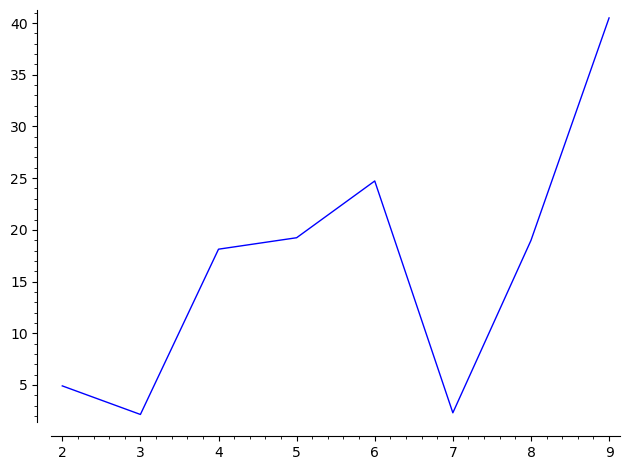

LOG MINIMUM MODULI


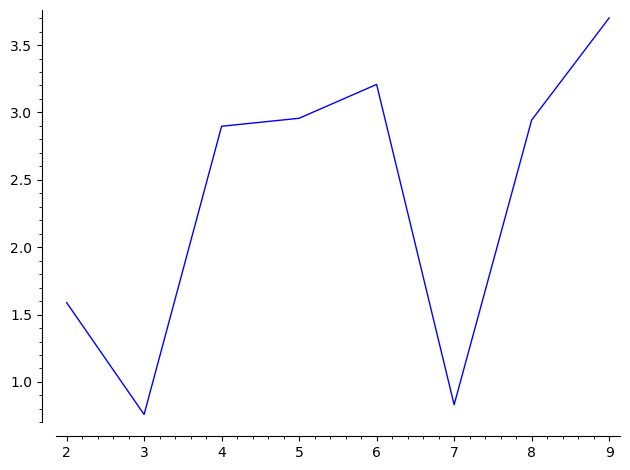

no log failures
Data range: n = 2 to 9
Number of data points: 8
Min modulus range: 2.135202 to 40.504527

Trend removed. Detrended data std dev: 0.9129

TOP DOMINANT PERIODICITIES (in index n)
Rank   Period       Frequency    Power          
----------------------------------------------------------------------
1            4.00     0.250000       1.73e+01


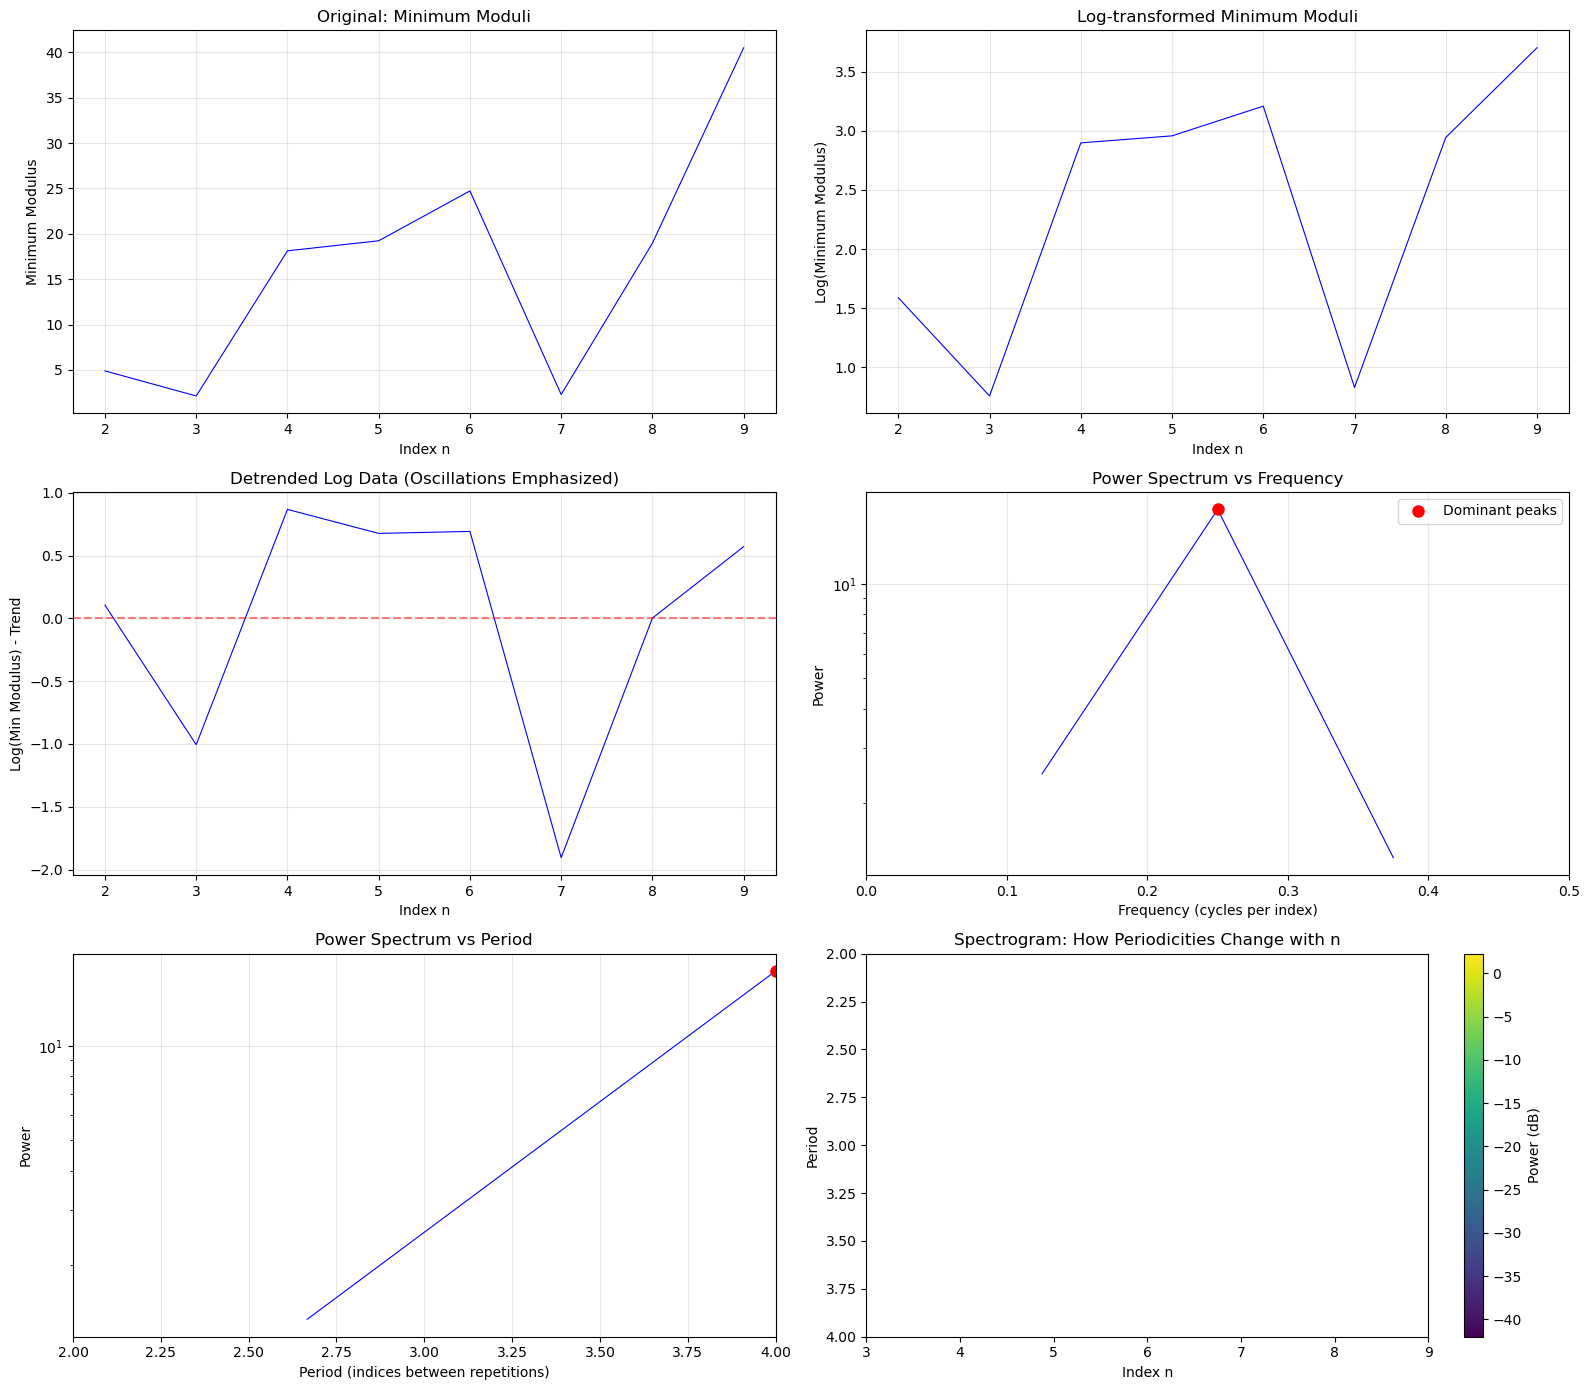


SIGNAL RECONSTRUCTION
Component 1: Period = 4.00, Amplitude = 0.1969


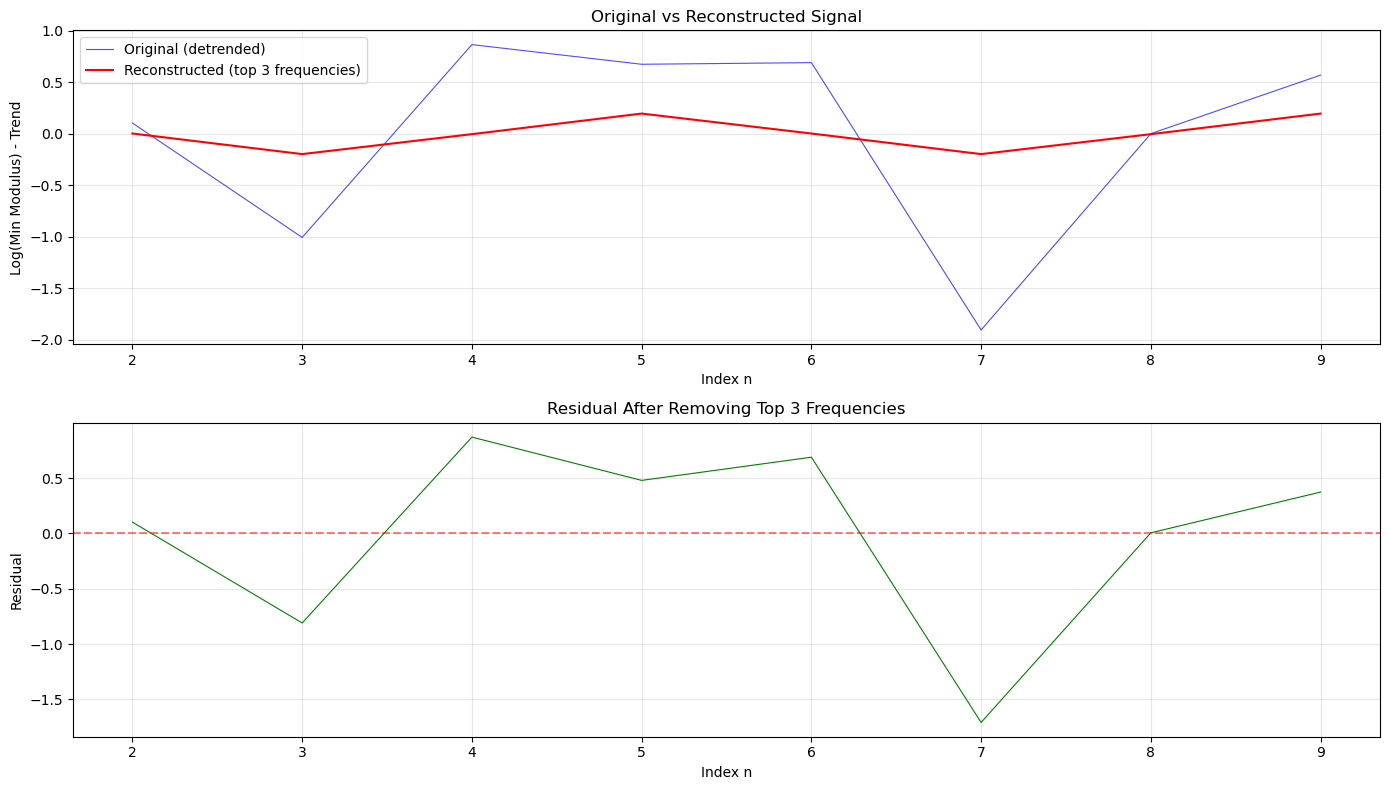


Analysis complete! Examine the plots and frequency table above.


In [60]:
import pickle
from sage.all import QQ, sigma, nth_prime, matrix, flatten, polygen, RR, CC, factorial
import ast
import math
from scipy.signal import find_peaks, correlate
from scipy.fft import fft, fftfreq
import numpy as np

Rc.<c> = RR[] # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< note
Rn.<n> = QQ[]
Rd.<d>=QQ[]
Rkk.<kk>=QQ[]

# Polynomial ring in c
Rc.<c> = QQ[]

def tau(n):
    def step1(n, k):
        return 35*k**4 - 52*k**3*n + 18*k**2*n**2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans += step1(n, k) * step2(n, k)
        return 24 * ans
    return n**4 * sigma(n) - step3(n)

def tau_prime(k):
    pn = nth_prime(k)
    return tau(pn)

def P_matrix(lst):
    lenlist = len(lst)
    columns = [lst]
    for k in range(1, lenlist):
        column = [0]*(k-1)
        column = column + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:lenlist]
        columns += [column]
    return (matrix(columns)).transpose()

precision_bits = 100
x = polygen(QQ)

start = time.time()

tau_prime_list = [(k, tau_prime(k)) for k in range(1, 11)]
h_list = [(0, 1)] + tau_prime_list

c_polys = []
degrees_check = []
checks = []

for n in range(2, 10):

    points_for_interpolation = []

    for c_val in range(1, 2*n):
        j_c_list = [(0, c_val)]

        for k in range(1, n+1):
            sm = 0
            for r in range(1, k):
                sm += j_c_list[r][1] * h_list[k-r][1]
            j_k = k * h_list[k][1] - sm
            j_c_list.append((k, j_k))

        j_c_values = [0] + [j_c_list[i][1] for i in range(len(j_c_list))]

        h_c = [1]
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k+1):
                sm += j_c_values[r] * h_c[k-r]
            h_c.append(sm / k)

        points_for_interpolation.append((c_val, h_c[n] * factorial(n)))

    # Lagrange interpolation
    c_poly = Rc.lagrange_polynomial(points_for_interpolation)
    c_polys.append((n, c_poly))
    degrees_check.append(n-c_poly.degree())

    # Boolean correctness check over ALL interpolation nodes
    ok = all(c_poly(c_val) == val for (c_val, val) in points_for_interpolation)
    checks.append(ok)

# Output
print("checks:")
print(checks)
print()
print("degrees check:")
print(degrees_check)
print()
for n, c_poly in c_polys:
    print("n:", n)
    print("c_poly:")
    print(c_poly)
    print()
with open('/Users/barrybrent/data2/run17feb26no8.txt', 'wb') as wfile:
    pickle.dump(c_polys, wfile) # ouput snipped

    
mins_list=[]
log_mins_list=[]
log_fails=[]
for tupl in c_polys:
    n=tupl[0]
    print(n)
    poly=tupl[1]
    roots=poly.roots(ring=CC, multiplicities=False)
    aar = [r.abs() for r in roots]
    if aar!=[]:
        minn = min(aar)  
        mins_list.append((n,minn))
        if minn>0:
            log_mins_list.append((n,log(minn)))
        if not(minn>0):
            log_fails.append(n)
        

p = list_plot(mins_list, plotjoined=True, axes_labels=['', ''])
print("MINIMUM MODULI")
p.show()


p = list_plot(log_mins_list, plotjoined=True, axes_labels=['', ''])
print("LOG MINIMUM MODULI")
p.show()
if log_fails:
    print(log_fails)
else:
    print("no log failures")

# FOURIER ANALYSIS OF MINIMUM MODULI
# This cell performs spectral analysis on the minimum moduli sequence
# to detect periodicities, dominant frequencies, and oscillatory patterns

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PREPARE THE DATA - Convert from SageMath to Python/NumPy types
# ==============================================================================

# Extract the data from mins_list and convert to Python floats
# This is crucial because SageMath uses its own numeric types
indices = np.array([float(pair[0]) for pair in mins_list], dtype=np.float64)
min_moduli = np.array([float(pair[1]) for pair in mins_list], dtype=np.float64)

# Also prepare the log-transformed data
log_min_moduli = np.log(min_moduli)

print(f"Data range: n = {int(indices[0])} to {int(indices[-1])}")
print(f"Number of data points: {len(indices)}")
print(f"Min modulus range: {min_moduli.min():.6f} to {min_moduli.max():.6f}")

# ==============================================================================
# 2. DETRENDING (Important for seeing oscillations)
# ==============================================================================

# For the log data, remove any polynomial trend to focus on oscillations
# We'll try both linear and quadratic detrending

# Linear detrend
log_detrended_linear = signal.detrend(log_min_moduli, type='linear')

# Polynomial detrend (degree 2)
poly_coeffs = np.polyfit(indices, log_min_moduli, deg=2)
poly_trend = np.polyval(poly_coeffs, indices)
log_detrended_poly = log_min_moduli - poly_trend

print(f"\nTrend removed. Detrended data std dev: {np.std(log_detrended_poly):.4f}")

# ==============================================================================
# 3. COMPUTE FOURIER TRANSFORM
# ==============================================================================

# Use FFT on the detrended log data
# The FFT reveals which "frequencies" (periodicities in n) are present

fft_result = np.fft.fft(log_detrended_poly)
fft_frequencies = np.fft.fftfreq(len(indices), d=1.0)  # d=1 means indices are spaced by 1

# Power spectrum (magnitude squared)
power_spectrum = np.abs(fft_result)**2

# Only keep positive frequencies (negative are redundant for real signals)
positive_freq_mask = fft_frequencies > 0
frequencies = fft_frequencies[positive_freq_mask]
power = power_spectrum[positive_freq_mask]

# Convert frequency to period: period = 1/frequency
# (period tells us "spikes repeat every X indices")
periods = 1.0 / frequencies

# ==============================================================================
# 4. IDENTIFY DOMINANT FREQUENCIES
# ==============================================================================

# Find the top 10 peaks in the power spectrum
peak_indices = signal.find_peaks(power, height=np.max(power)*0.1)[0]  # peaks at least 10% of max
peak_powers = power[peak_indices]
peak_periods = periods[peak_indices]

# Sort by power (strongest first)
sorted_indices = np.argsort(peak_powers)[::-1]
top_peaks = sorted_indices[:min(10, len(sorted_indices))]

print("\n" + "="*70)
print("TOP DOMINANT PERIODICITIES (in index n)")
print("="*70)
print(f"{'Rank':<6} {'Period':<12} {'Frequency':<12} {'Power':<15}")
print("-"*70)
for rank, idx in enumerate(top_peaks, 1):
    period = peak_periods[idx]
    freq = frequencies[peak_indices[idx]]
    pwr = peak_powers[idx]
    print(f"{rank:<6} {period:>10.2f}   {freq:>10.6f}   {pwr:>12.2e}")

# ==============================================================================
# 5. VISUALIZATIONS
# ==============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 5.1: Original data (linear scale)
axes[0, 0].plot(indices, min_moduli, 'b-', linewidth=0.8)
axes[0, 0].set_xlabel('Index n')
axes[0, 0].set_ylabel('Minimum Modulus')
axes[0, 0].set_title('Original: Minimum Moduli')
axes[0, 0].grid(True, alpha=0.3)

# Plot 5.2: Log scale data
axes[0, 1].plot(indices, log_min_moduli, 'b-', linewidth=0.8)
axes[0, 1].set_xlabel('Index n')
axes[0, 1].set_ylabel('Log(Minimum Modulus)')
axes[0, 1].set_title('Log-transformed Minimum Moduli')
axes[0, 1].grid(True, alpha=0.3)

# Plot 5.3: Detrended data (shows oscillations more clearly)
axes[1, 0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8)
axes[1, 0].set_xlabel('Index n')
axes[1, 0].set_ylabel('Log(Min Modulus) - Trend')
axes[1, 0].set_title('Detrended Log Data (Oscillations Emphasized)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 5.4: Power Spectrum vs Frequency
axes[1, 1].semilogy(frequencies, power, 'b-', linewidth=0.8)
axes[1, 1].semilogy(frequencies[peak_indices[top_peaks]], 
                     peak_powers[top_peaks], 'ro', markersize=8, label='Dominant peaks')
axes[1, 1].set_xlabel('Frequency (cycles per index)')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('Power Spectrum vs Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 0.5)  # Nyquist limit

# Plot 5.5: Power Spectrum vs Period (often more intuitive)
# Only plot periods up to half the data length (longer periods unreliable)
max_period = len(indices) / 2
period_mask = periods <= max_period
axes[2, 0].semilogy(periods[period_mask], power[period_mask], 'b-', linewidth=0.8)
# Mark dominant periods
for idx in top_peaks:
    if peak_periods[idx] <= max_period:
        axes[2, 0].semilogy(peak_periods[idx], peak_powers[idx], 'ro', markersize=8)
axes[2, 0].set_xlabel('Period (indices between repetitions)')
axes[2, 0].set_ylabel('Power')
axes[2, 0].set_title('Power Spectrum vs Period')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_xlim(2, max_period)

# Plot 5.6: Spectrogram (time-frequency analysis using Short-Time Fourier Transform)
# This shows if periodicities change over the sequence
window_size = min(64, len(indices)//4)  # adaptive window size
f_spec, t_spec, Sxx = signal.spectrogram(log_detrended_poly, fs=1.0, 
                                          nperseg=window_size, 
                                          noverlap=window_size//2)
# Convert frequency axis to period for easier interpretation
period_spec = 1.0 / (f_spec + 1e-10)  # avoid division by zero
period_spec = period_spec[1:]  # remove DC component
Sxx = Sxx[1:, :]

# Plot with period on y-axis (inverted so small periods at bottom)
im = axes[2, 1].pcolormesh(indices[0] + t_spec, period_spec, 10*np.log10(Sxx + 1e-10),
                           shading='gouraud', cmap='viridis')
axes[2, 1].set_xlabel('Index n')
axes[2, 1].set_ylabel('Period')
axes[2, 1].set_title('Spectrogram: How Periodicities Change with n')
axes[2, 1].set_ylim(2, min(100, max_period))
axes[2, 1].invert_yaxis()  # small periods at bottom
plt.colorbar(im, ax=axes[2, 1], label='Power (dB)')

plt.tight_layout()
plt.show()

# ==============================================================================
# 6. FILTERED SIGNAL (reconstruct using only dominant frequencies)
# ==============================================================================

# Reconstruct signal using only the top 3 dominant frequencies
# This shows what the "pure" oscillatory pattern looks like

print("\n" + "="*70)
print("SIGNAL RECONSTRUCTION")
print("="*70)

reconstructed = np.zeros_like(log_detrended_poly)
for rank, idx in enumerate(top_peaks[:3], 1):  # Use top 3 frequencies
    freq = frequencies[peak_indices[idx]]
    period = peak_periods[idx]
    # Get amplitude and phase from FFT
    amp = np.abs(fft_result[peak_indices[idx]]) / len(indices)
    phase = np.angle(fft_result[peak_indices[idx]])
    # Reconstruct this component
    component = amp * np.cos(2 * np.pi * freq * indices + phase)
    reconstructed += component
    print(f"Component {rank}: Period = {period:.2f}, Amplitude = {amp:.4f}")

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8, alpha=0.7, label='Original (detrended)')
axes[0].plot(indices, reconstructed, 'r-', linewidth=1.5, label='Reconstructed (top 3 frequencies)')
axes[0].set_xlabel('Index n')
axes[0].set_ylabel('Log(Min Modulus) - Trend')
axes[0].set_title('Original vs Reconstructed Signal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual (what's left after removing dominant frequencies)
residual = log_detrended_poly - reconstructed
axes[1].plot(indices, residual, 'g-', linewidth=0.8)
axes[1].set_xlabel('Index n')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual After Removing Top 3 Frequencies')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Analysis complete! Examine the plots and frequency table above.")
print("="*70)

first block 2
first block 3
first block 4
first block 5
first block 6
first block 7
first block 8
first block 9
first block 10
first block 11
first block 12
first block 13
first block 14
first block 15
first block 16
first block 17
first block 18
first block 19
first block 20
first block 21
first block 22
first block 23
first block 24
first block 25
first block 26
first block 27
first block 28
first block 29
first block 30
first block 31
first block 32
first block 33
first block 34
first block 35
first block 36
first block 37
first block 38
first block 39
first block 40
first block 41
first block 42
first block 43
first block 44
first block 45
first block 46
first block 47
first block 48
first block 49
first block 50
first block 51
first block 52
first block 53
first block 54
first block 55
first block 56
first block 57
first block 58
first block 59
first block 60
first block 61
first block 62
first block 63
first block 64
first block 65
first block 66
first block 67
first block 68
fir

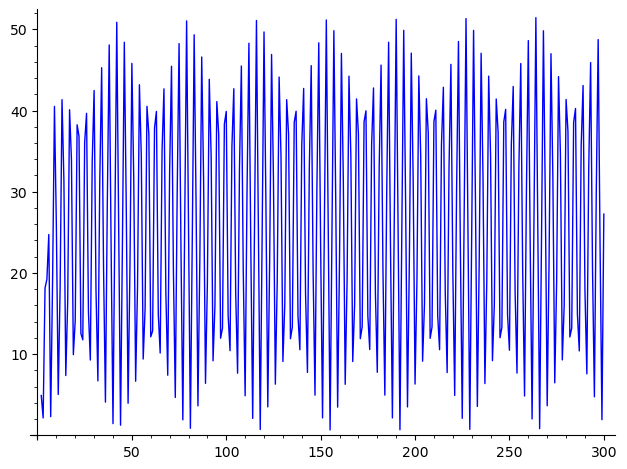

LOG MINIMUM MODULI


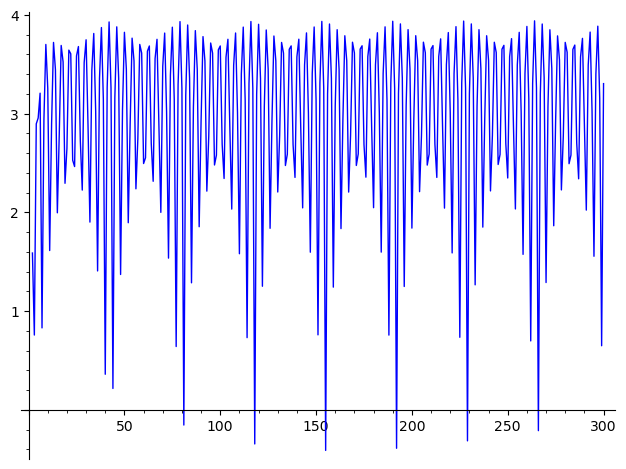

no log failures
Data range: n = 2 to 300
Number of data points: 299
Min modulus range: 0.663745 to 51.440233

Trend removed. Detrended data std dev: 0.9378

TOP DOMINANT PERIODICITIES (in index n)
Rank   Period       Frequency    Power          
----------------------------------------------------------------------
1            4.10     0.244147       2.29e+04


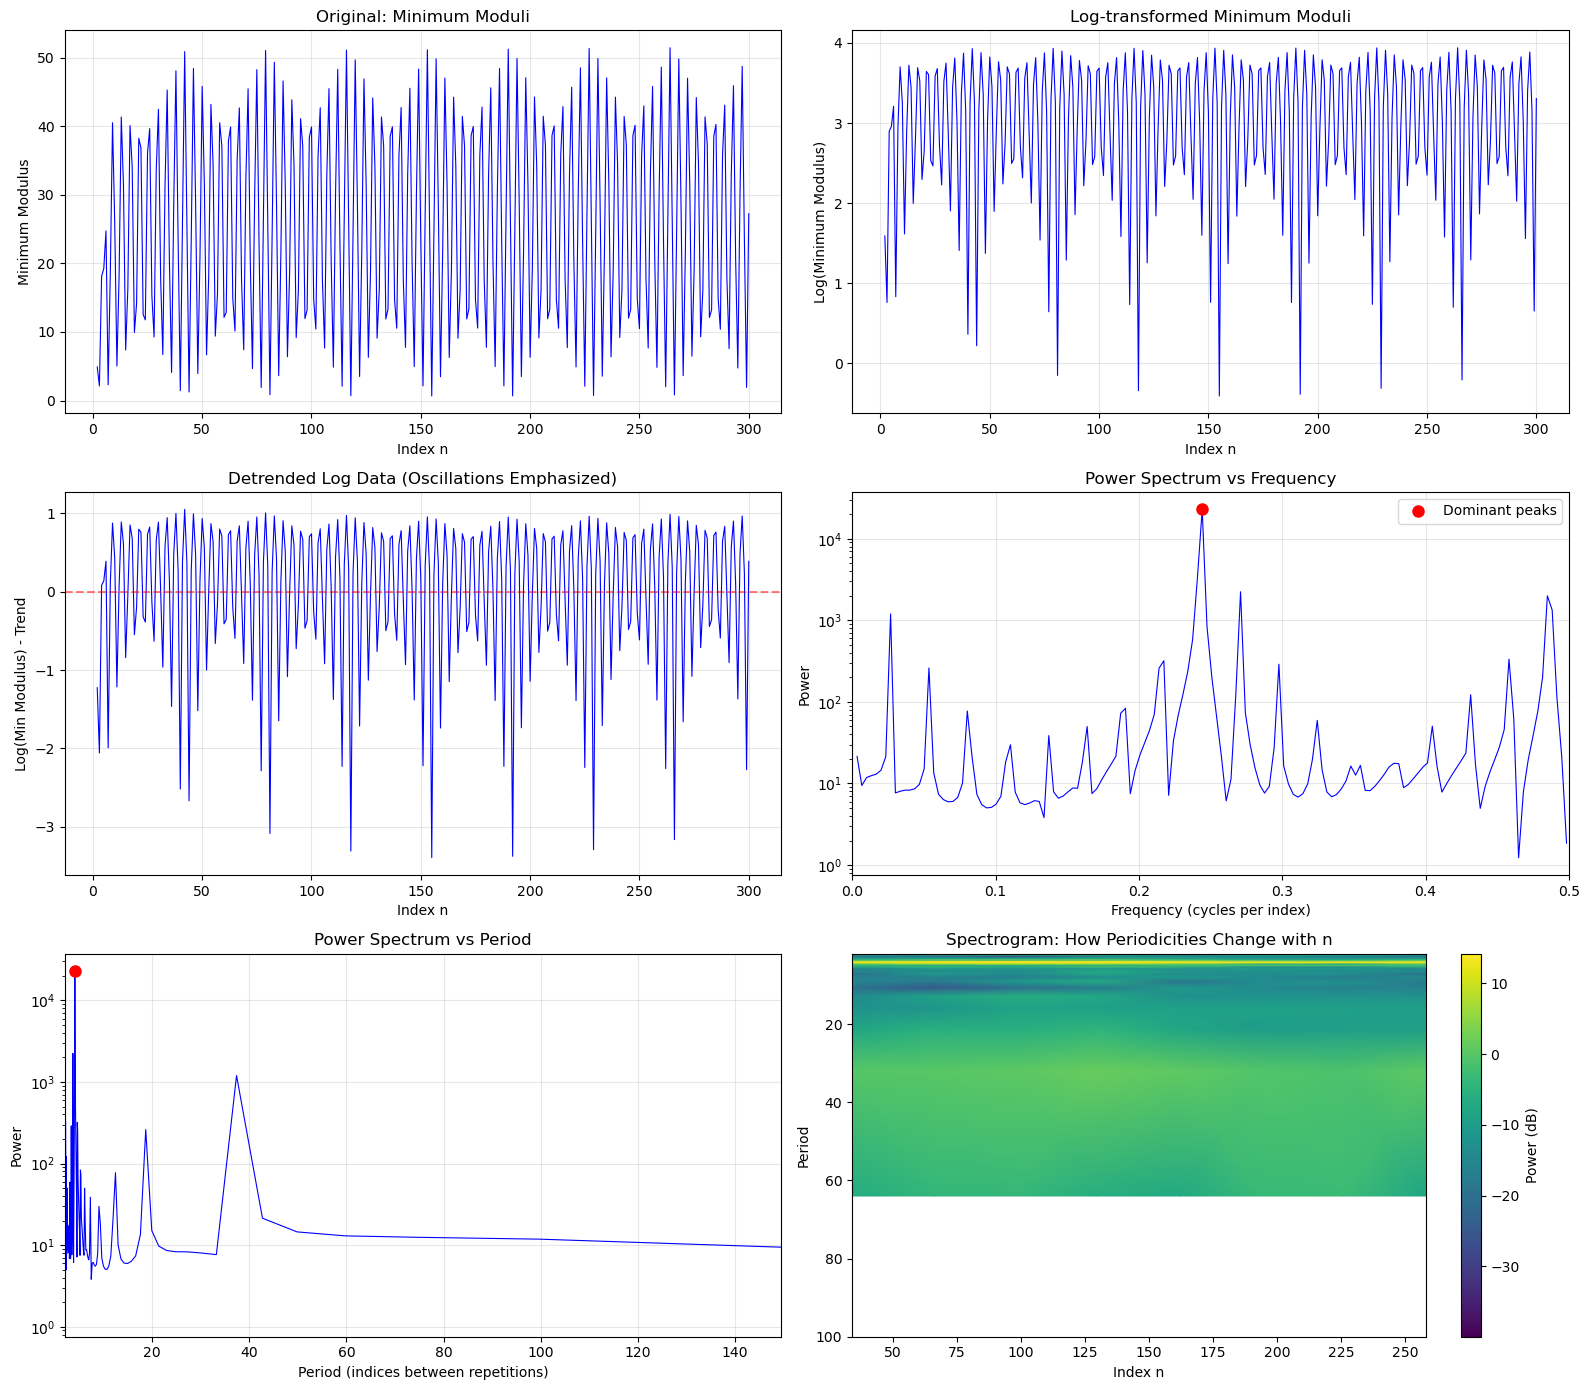


SIGNAL RECONSTRUCTION
Component 1: Period = 4.10, Amplitude = 0.1922


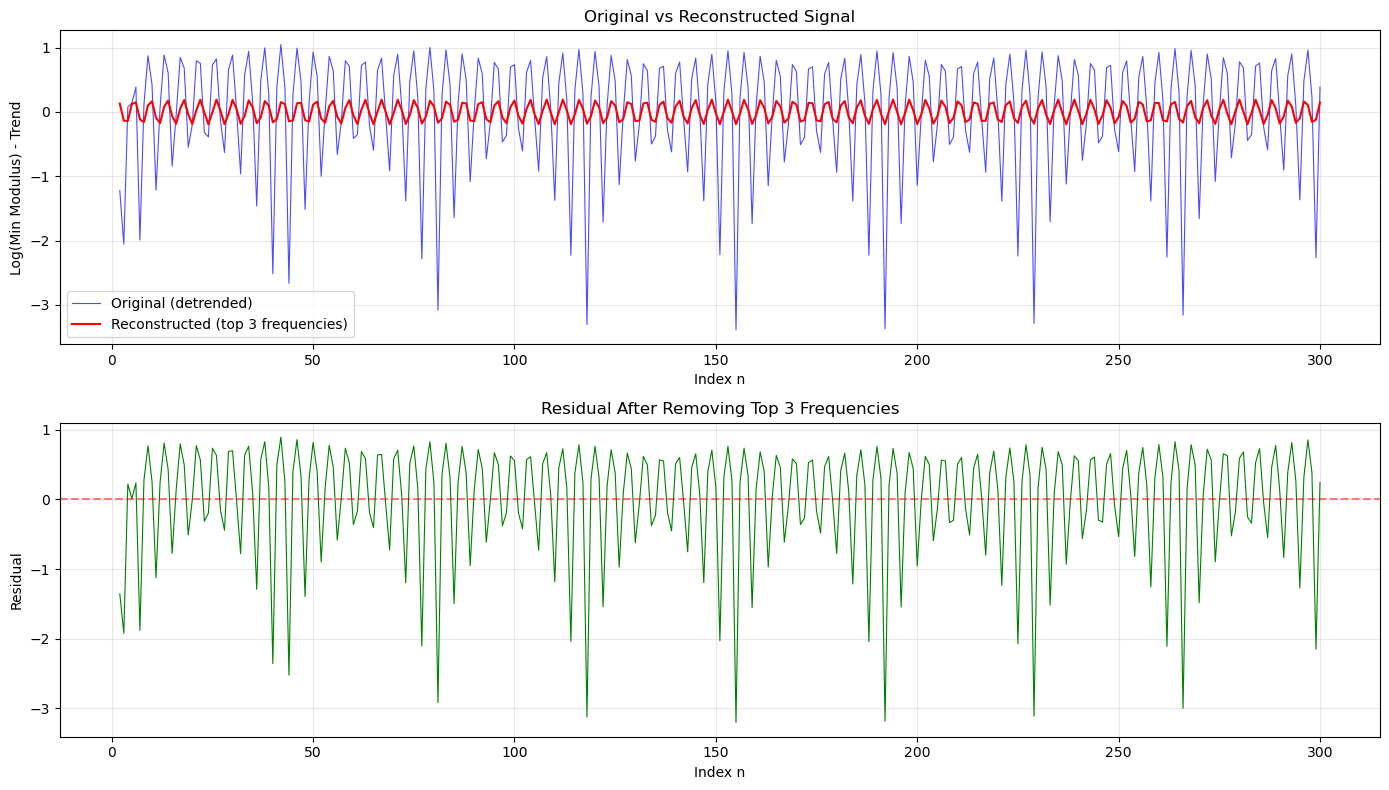


Analysis complete! Examine the plots and frequency table above.


In [63]:
import pickle
from sage.all import QQ, sigma, nth_prime, matrix, flatten, polygen, RR, CC, factorial
import ast
import math
from scipy.signal import find_peaks, correlate
from scipy.fft import fft, fftfreq
import numpy as np

Rc.<c> = QQ[] # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< note
Rn.<n> = QQ[]
Rd.<d>=QQ[]
Rkk.<kk>=QQ[]

# Polynomial ring in c
Rc.<c> = QQ[]

def tau(n):
    def step1(n, k):
        return 35*k**4 - 52*k**3*n + 18*k**2*n**2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans += step1(n, k) * step2(n, k)
        return 24 * ans
    return n**4 * sigma(n) - step3(n)

def tau_prime(k):
    pn = nth_prime(k)
    return tau(pn)

def P_matrix(lst):
    lenlist = len(lst)
    columns = [lst]
    for k in range(1, lenlist):
        column = [0]*(k-1)
        column = column + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:lenlist]
        columns += [column]
    return (matrix(columns)).transpose()

precision_bits = 100
x = polygen(QQ)

start = time.time()

tau_prime_list = [(k, tau_prime(k)) for k in range(1, 401)]
h_list = [(0, 1)] + tau_prime_list

c_polys = []
degrees_check = []
checks = []

for n in range(2, 301):
    print("first block",n)
    points_for_interpolation = []

    for c_val in range(1, 2*n):
        j_c_list = [(0, c_val)]

        for k in range(1, n+1):
            sm = 0
            for r in range(1, k):
                sm += j_c_list[r][1] * h_list[k-r][1]
            j_k = k * h_list[k][1] - sm
            j_c_list.append((k, j_k))

        j_c_values = [0] + [j_c_list[i][1] for i in range(len(j_c_list))]

        h_c = [1]
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k+1):
                sm += j_c_values[r] * h_c[k-r]
            h_c.append(sm / k)

        points_for_interpolation.append((c_val, h_c[n] * factorial(n)))

    # Lagrange interpolation
    c_poly = Rc.lagrange_polynomial(points_for_interpolation)
    c_polys.append((n, c_poly))
    degrees_check.append(n-c_poly.degree())

    # Boolean correctness check over ALL interpolation nodes
    ok = all(c_poly(c_val) == val for (c_val, val) in points_for_interpolation)
    checks.append(ok)

# Output
print("checks:")
print(checks)
print()
print("degrees check:")
print(degrees_check)
print()


    
mins_list=[]
log_mins_list=[]
log_fails=[]
for tupl in c_polys:
    n=tupl[0]
    print("second block",n)
    poly=tupl[1]
    roots=poly.roots(ring=CC, multiplicities=False)
    aar = [r.abs() for r in roots]
    if aar!=[]:
        minn = min(aar)  
        mins_list.append((n,minn))
        if minn>0:
            log_mins_list.append((n,log(minn)))
        if not(minn>0):
            log_fails.append(n)
        

p = list_plot(mins_list, plotjoined=True, axes_labels=['', ''])
print("MINIMUM MODULI")
p.show()


p = list_plot(log_mins_list, plotjoined=True, axes_labels=['', ''])
print("LOG MINIMUM MODULI")
p.show()
if log_fails:
    print(log_fails)
else:
    print("no log failures")

# FOURIER ANALYSIS OF MINIMUM MODULI
# This cell performs spectral analysis on the minimum moduli sequence
# to detect periodicities, dominant frequencies, and oscillatory patterns

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PREPARE THE DATA - Convert from SageMath to Python/NumPy types
# ==============================================================================

# Extract the data from mins_list and convert to Python floats
# This is crucial because SageMath uses its own numeric types
indices = np.array([float(pair[0]) for pair in mins_list], dtype=np.float64)
min_moduli = np.array([float(pair[1]) for pair in mins_list], dtype=np.float64)

# Also prepare the log-transformed data
log_min_moduli = np.log(min_moduli)

print(f"Data range: n = {int(indices[0])} to {int(indices[-1])}")
print(f"Number of data points: {len(indices)}")
print(f"Min modulus range: {min_moduli.min():.6f} to {min_moduli.max():.6f}")

# ==============================================================================
# 2. DETRENDING (Important for seeing oscillations)
# ==============================================================================

# For the log data, remove any polynomial trend to focus on oscillations
# We'll try both linear and quadratic detrending

# Linear detrend
log_detrended_linear = signal.detrend(log_min_moduli, type='linear')

# Polynomial detrend (degree 2)
poly_coeffs = np.polyfit(indices, log_min_moduli, deg=2)
poly_trend = np.polyval(poly_coeffs, indices)
log_detrended_poly = log_min_moduli - poly_trend

print(f"\nTrend removed. Detrended data std dev: {np.std(log_detrended_poly):.4f}")

# ==============================================================================
# 3. COMPUTE FOURIER TRANSFORM
# ==============================================================================

# Use FFT on the detrended log data
# The FFT reveals which "frequencies" (periodicities in n) are present

fft_result = np.fft.fft(log_detrended_poly)
fft_frequencies = np.fft.fftfreq(len(indices), d=1.0)  # d=1 means indices are spaced by 1

# Power spectrum (magnitude squared)
power_spectrum = np.abs(fft_result)**2

# Only keep positive frequencies (negative are redundant for real signals)
positive_freq_mask = fft_frequencies > 0
frequencies = fft_frequencies[positive_freq_mask]
power = power_spectrum[positive_freq_mask]

# Convert frequency to period: period = 1/frequency
# (period tells us "spikes repeat every X indices")
periods = 1.0 / frequencies

# ==============================================================================
# 4. IDENTIFY DOMINANT FREQUENCIES
# ==============================================================================

# Find the top 10 peaks in the power spectrum
peak_indices = signal.find_peaks(power, height=np.max(power)*0.1)[0]  # peaks at least 10% of max
peak_powers = power[peak_indices]
peak_periods = periods[peak_indices]

# Sort by power (strongest first)
sorted_indices = np.argsort(peak_powers)[::-1]
top_peaks = sorted_indices[:min(10, len(sorted_indices))]

print("\n" + "="*70)
print("TOP DOMINANT PERIODICITIES (in index n)")
print("="*70)
print(f"{'Rank':<6} {'Period':<12} {'Frequency':<12} {'Power':<15}")
print("-"*70)
for rank, idx in enumerate(top_peaks, 1):
    period = peak_periods[idx]
    freq = frequencies[peak_indices[idx]]
    pwr = peak_powers[idx]
    print(f"{rank:<6} {period:>10.2f}   {freq:>10.6f}   {pwr:>12.2e}")

# ==============================================================================
# 5. VISUALIZATIONS
# ==============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 5.1: Original data (linear scale)
axes[0, 0].plot(indices, min_moduli, 'b-', linewidth=0.8)
axes[0, 0].set_xlabel('Index n')
axes[0, 0].set_ylabel('Minimum Modulus')
axes[0, 0].set_title('Original: Minimum Moduli')
axes[0, 0].grid(True, alpha=0.3)

# Plot 5.2: Log scale data
axes[0, 1].plot(indices, log_min_moduli, 'b-', linewidth=0.8)
axes[0, 1].set_xlabel('Index n')
axes[0, 1].set_ylabel('Log(Minimum Modulus)')
axes[0, 1].set_title('Log-transformed Minimum Moduli')
axes[0, 1].grid(True, alpha=0.3)

# Plot 5.3: Detrended data (shows oscillations more clearly)
axes[1, 0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8)
axes[1, 0].set_xlabel('Index n')
axes[1, 0].set_ylabel('Log(Min Modulus) - Trend')
axes[1, 0].set_title('Detrended Log Data (Oscillations Emphasized)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 5.4: Power Spectrum vs Frequency
axes[1, 1].semilogy(frequencies, power, 'b-', linewidth=0.8)
axes[1, 1].semilogy(frequencies[peak_indices[top_peaks]], 
                     peak_powers[top_peaks], 'ro', markersize=8, label='Dominant peaks')
axes[1, 1].set_xlabel('Frequency (cycles per index)')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('Power Spectrum vs Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 0.5)  # Nyquist limit

# Plot 5.5: Power Spectrum vs Period (often more intuitive)
# Only plot periods up to half the data length (longer periods unreliable)
max_period = len(indices) / 2
period_mask = periods <= max_period
axes[2, 0].semilogy(periods[period_mask], power[period_mask], 'b-', linewidth=0.8)
# Mark dominant periods
for idx in top_peaks:
    if peak_periods[idx] <= max_period:
        axes[2, 0].semilogy(peak_periods[idx], peak_powers[idx], 'ro', markersize=8)
axes[2, 0].set_xlabel('Period (indices between repetitions)')
axes[2, 0].set_ylabel('Power')
axes[2, 0].set_title('Power Spectrum vs Period')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_xlim(2, max_period)

# Plot 5.6: Spectrogram (time-frequency analysis using Short-Time Fourier Transform)
# This shows if periodicities change over the sequence
window_size = min(64, len(indices)//4)  # adaptive window size
f_spec, t_spec, Sxx = signal.spectrogram(log_detrended_poly, fs=1.0, 
                                          nperseg=window_size, 
                                          noverlap=window_size//2)
# Convert frequency axis to period for easier interpretation
period_spec = 1.0 / (f_spec + 1e-10)  # avoid division by zero
period_spec = period_spec[1:]  # remove DC component
Sxx = Sxx[1:, :]

# Plot with period on y-axis (inverted so small periods at bottom)
im = axes[2, 1].pcolormesh(indices[0] + t_spec, period_spec, 10*np.log10(Sxx + 1e-10),
                           shading='gouraud', cmap='viridis')
axes[2, 1].set_xlabel('Index n')
axes[2, 1].set_ylabel('Period')
axes[2, 1].set_title('Spectrogram: How Periodicities Change with n')
axes[2, 1].set_ylim(2, min(100, max_period))
axes[2, 1].invert_yaxis()  # small periods at bottom
plt.colorbar(im, ax=axes[2, 1], label='Power (dB)')

plt.tight_layout()
plt.show()

# ==============================================================================
# 6. FILTERED SIGNAL (reconstruct using only dominant frequencies)
# ==============================================================================

# Reconstruct signal using only the top 3 dominant frequencies
# This shows what the "pure" oscillatory pattern looks like

print("\n" + "="*70)
print("SIGNAL RECONSTRUCTION")
print("="*70)

reconstructed = np.zeros_like(log_detrended_poly)
for rank, idx in enumerate(top_peaks[:3], 1):  # Use top 3 frequencies
    freq = frequencies[peak_indices[idx]]
    period = peak_periods[idx]
    # Get amplitude and phase from FFT
    amp = np.abs(fft_result[peak_indices[idx]]) / len(indices)
    phase = np.angle(fft_result[peak_indices[idx]])
    # Reconstruct this component
    component = amp * np.cos(2 * np.pi * freq * indices + phase)
    reconstructed += component
    print(f"Component {rank}: Period = {period:.2f}, Amplitude = {amp:.4f}")

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8, alpha=0.7, label='Original (detrended)')
axes[0].plot(indices, reconstructed, 'r-', linewidth=1.5, label='Reconstructed (top 3 frequencies)')
axes[0].set_xlabel('Index n')
axes[0].set_ylabel('Log(Min Modulus) - Trend')
axes[0].set_title('Original vs Reconstructed Signal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual (what's left after removing dominant frequencies)
residual = log_detrended_poly - reconstructed
axes[1].plot(indices, residual, 'g-', linewidth=0.8)
axes[1].set_xlabel('Index n')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual After Removing Top 3 Frequencies')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Analysis complete! Examine the plots and frequency table above.")
print("="*70)

with open('/Users/barrybrent/data2/run17feb26no9.txt', 'wb') as wfile:
    pickle.dump(c_polys, wfile)
with open('/Users/barrybrent/data2/run17feb26no10.txt', 'wb') as wfile:
    pickle.dump(mins_list, wfile)
with open('/Users/barrybrent/data2/run17feb26no11.txt', 'wb') as wfile:
    pickle.dump(log_mins_list, wfile)
